# Moar  Attention Mechanism!

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
#Abrimos el archivo con los nombres
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()[:10000] # Usamos solo el primer millon de dominios
dataset[:8]

In [ ]:
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_len = len(charset)
print(ctoi)

In [ ]:
def build_dataset(dataset: list):
    X, Y  = [], []
    for d in dataset:
        example = list(d) + ['*']
        context = [0] * context_size
        for c in example:
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]] 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [ ]:
# build the dataset
context_size = 3
np.random.seed(42)
np.random.shuffle(dataset)
n1 = int(.8 * len(dataset))  # límite para el 80% del dataset
n2 = int(.9 * len(dataset))  # límite para el 90% del dataset
Xtr, Ytr = build_dataset(dataset[:n1])    # 80%
Xva, Yva = build_dataset(dataset[n1:n2])  # 10%
Xte, Yte = build_dataset(dataset[:n2])    # 10%

In [ ]:
g = torch.Generator(device='cpu').manual_seed(42)
emb_d = 10  # El número de dimensiones del Enbedding
input_size = context_size * emb_d  # el tamaño del input, desapilado
head_size = 8 

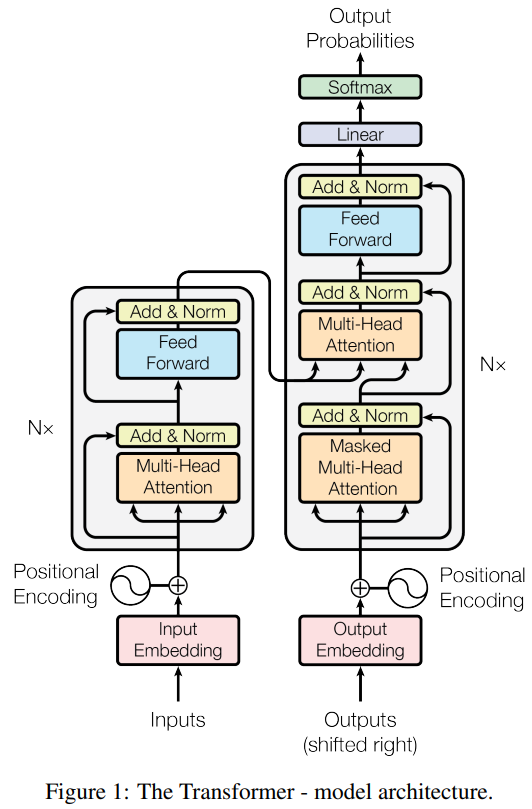

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(emb_d, head_size, bias=False)
        self.query = nn.Linear(emb_d, head_size, bias=False)
        self.value = nn.Linear(emb_d, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.T * C **-.5
        #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        #wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(emb_d, emb_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_d, num_heads):
        super().__init__()
        head_size = emb_d // num_heads
        self.sa = MultiHead(num_heads, head_size)
        self.ffwd = nn.Linear(emb_d)
        self.ln1 = nn.LayerNorm(emb_d)
        self.ln2 = nn.LayerNorm(emb_d)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x